# Balancing a Ball on a Beam with Proportional-Derivative Control

###### The latest version of this Jupyter notebook is available at [http://github.com/jckantor/Ball-and-Beam](http://github.com/jckantor/Ball-and-Beam)  for noncommercial use under terms of the [Creative Commons Attribution Noncommericial ShareAlike License](http://creativecommons.org/licenses/by-nc-sa/4.0/).

Jeffrey C. Kantor (Kantor.1@nd.edu)

This notebook illustrates the principles of proportional-derivative feedback through an interactive simulation of a ball on beam apparatus. The task is to choose the control parameters to balance the ball at desired locations on the beam with acceptable dynamics and without rolling off the ends. 

<img align="center" src="ballbeam.png" alt="Ball and Beam Screenshot" title="Ball and Beam" width="640">

The simulation in intended for use in as in-lecture demonstration on PD control and the dynamics of second order systems, and for out-of-class reinforcement of key concepts in feedback control. Suggested exercises are included.

Everything is included in a single, self-contained Jupyter notebook using standard python libraries.

## Table of Contents

* [Initialization](#Initialization). This section loads needed libraries and defines functions to display and update a diagram of the ball and beam apparatus, and to create plots of the ball position and beam angle. These cells need to be executed for subsequent simulations.
* [Ball on Beam Dynamics](#Simulation/Animation). This section presents a model for the dynamics of the ball on beam system, and demonstrates the behavior with an open-loop simulation of the device.
* [Proportional-Derivative Control](#Proportional-Derivative Control). This section introduces a proportional-derivative feedback control. Simulations can be run for different choices of setpoints and control parameters.
* [Theory](#Theory). A derivation of an approximate linear model for the dynamics of the ball on beam system under proportional-derivative control.
* [Exercises](#Exercises). A short set of exercises to reinforce control concepts, and introduce methods to analyze the performance of the ball on beam control system.

## How to Use

The simplest way to use this notebook is to run it in the cloud. This can be done from any browser (laptop, tablet, phone), and doesn't require any software installation. Click this button to get started:

[![Binder](http://mybinder.org/badge.svg)](http://mybinder.org/repo/jckantor/Ball-and-Beam)

Alternatively the notebook can be downloaded to your laptop and run as a standard Jupyter notebook. This requires prior installation of a Python 2.7 distribution with standard libraries such as [Anaconda](https://www.continuum.io/) available from Continuum Analytics, or [Canopy](https://www.enthought.com/) available from Enthought, Inc.

Once the notebook is loaded in an executable environment, either in the cloud or laptop, proceed through the notebook executing each cell, one at a time. You can use either the `run` button in the Jupyter tool bar, or press `shift-enter` for each cell. Be sure to run the Initialization cell first!

<a id='Initialization'></a>
## Initialization (Run this one first!)

The following cell contains utility functions used to display and update a figure illustrating the ball and beam apparatus. This cell must be executed in order to run the control simulations later in this notebook. The detail of these functions can be safely ignored by anyone primarily interested in the subsequent applications of feedback control.

In [1]:
%matplotlib notebook

from pylab import *
import time
from ipywidgets import interact, interactive

# limit on beam angle in radians
ulimit = 0.2

def draw_beam(fig,ax):
    # Draw the ball and beam diagram on a given figure and axis
    ax.axis('off')
    ax.axis('equal')
    ax.set(xlim = (-0.2,1.2), ylim = (-0.3,0.3))
    
    # draw ball, beam, and set point patch
    ax.plot(0.5,0.049,'r.',ms=50)
    ax.plot(array([0.0,cos(0.0)]), array([0.0,sin(0.0)]), lw=5)
    ax.add_patch(Polygon([[0.5, -0.01], [0.5-0.03, -0.05], [0.5+0.03, -0.05]]))

    # draw pivot patch
    ax.add_patch(Polygon([[0.0,0.0],[0.02,-0.25],[-0.02,-0.25]]))
    
    # beam hi and lo limit patches
    ulimit = 0.2
    xa = cos(ulimit)
    ya = sin(ulimit)
    ax.add_patch(Polygon([[xa-0.05, ya+0.01],[xa+0.05, ya+0.01], \
                          [xa+0.05, ya+0.02],[xa-0.05, ya+0.02]]))
    ax.add_patch(Polygon([[xa-0.05,-ya-0.01],[xa+0.05,-ya-0.01], \
                          [xa+0.05,-ya-0.02],[xa-0.05,-ya-0.02]]))
    fig.canvas.draw()

def update_beam(fig,ax,x,u,SP):
    # Update the ball and beam diagram with current state values.
    
    # Limit beam angle
    u = -ulimit if u < -ulimit else ulimit if u > ulimit else u
    
    # Determine ball position, and if it rolled off the beam
    x = -0.05 if x < 0 else 1.02 if x > 1.0 else x
    y = 0.049/cos(u) + x*sin(u) if x >= 0.0 and x <= 1.0 else -0.2

    # update ball, beam, and setpoint positions
    ax.lines[0].set(xdata=x, ydata=y)
    ax.lines[1].set(xdata=[0.0,cos(u)], ydata=[0.0,sin(u)])
    ax.patches[0].set_xy([[SP*cos(u), -0.01 + SP*sin(u)], \
              [SP*cos(u) - 0.03, -0.05 + SP*sin(u)], \
              [SP*cos(u) + 0.03, -0.05 + SP*sin(u)]])
    fig.canvas.draw()
    
def draw_plot(fig,ax,SP):
    
    # set up xplot to display ball position
    xplot = ax
    xplot.set(xlim=(0,tf),ylim=(0,1),xlabel='Time [dimensionless]',ylabel='Position')
    xplot.plot([],[],'b')
    xplot.plot([0,tf],[SP,SP],'b--')

    # set up second axist to display beam angle
    uplot = ax.twinx()
    uplot.set(xlim=(0,tf),ylim=(-ulimit,ulimit))
    uplot.set_ylabel('Beam Angle', color='r')
    for tl in uplot.get_yticklabels():
        tl.set_color('r')
    uplot.plot([],[],'r')
    uplot.plot([0,tf],[0,0],'r--')
    
    # return lines for updating
    return xplot,uplot

def update_plot(ax,t,y):
    tdata = append(ax.lines[0].get_xdata(),t)
    ydata = append(ax.lines[0].get_ydata(),y)
    ax.lines[0].set(xdata=tdata, ydata=ydata)
    

<a id='Ball on Beam Dynamics'></a>
## Ball on Beam Dynamics

We assume that a ball can roll freely and without friction on a tilted beam. The beam angle $u$ is measured in a counterclockwise direction from the horizontal, and is subject to the hard limits indicated by stops on the following diagram.  The position of the ball is given by $x$ on a beam of length $L$. The ball can fall of the either end of the beam. There is a triangular marker below the beam to indicate the location of a setpoint.

Run the following cell to see a diagram of the ball and beam apparatus.

<IPython.core.display.Javascript object>


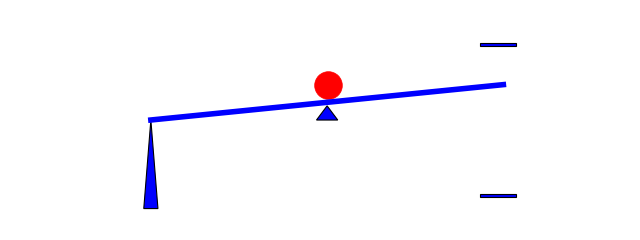

In [2]:
fig,ax = subplots(1,1,figsize=(8,3))
draw_beam(fig,ax)
update_beam(fig,ax,0.5,0.1,0.5)

The ball dynamics are modeled by a pair of differential equations

\begin{align}
\frac{dx}{dt} & = v(t) \\
(I+1)m\frac{dv}{dt} & = - m g \sin(u(t))
\end{align}

where $x(t)$ denotes position of the ball on the beam, $v(t)$ is velocity, $u(t)$ is the angle of the beam relative to the horizontal, $m$ is the ball mass, and $g$ is acceleration due to gravity.

The motion of the ball is subject to both linear and rotational inertia. The linear inertia is the product of the ball's mass times acceleration. If the surface of the ball doesn't slip as it rolls on the beam, the rotational inertia can be expressed as a mutiple $I$ of the ball's mass where $I = \frac{2}{5}$ for a solid sphere, or $I = \frac{2}{3}$ for a spherical shell. Wrapping these parameters into a single constant $K_b = \frac{g}{1+I}$ results in a model

\begin{align}
\frac{dx}{dt} & = v(t) \\
\frac{dv}{dt} & = - K_b \sin(u(t))
\end{align}

where the variables all have common units.

An alternative is create a dimensionless model where a time scale $T$ is defined by

$$T  = \sqrt{\frac{(1+\alpha)L}{g}}$$

where $L$ is the length of the beam. Dimensionless variables are then given

\begin{align*}
\tilde{x} & = \frac{x}{L} \\
\tilde{t} & = \frac{t}{T} \\
\tilde{v} & = \frac{v T}{L}
\end{align*}

With these definitions in place, our simulation model becomes dimensionless where

\begin{align*}
\frac{d\tilde{x}}{d\tilde{t}} & = \tilde{v}(\tilde{t}) \\
\frac{d\tilde{v}}{d\tilde{t}} & = - \sin(u(\tilde{t}))
\end{align*}

Note the dimensionless model can be formed from the dimensional model with specific choices for $K_b$ and $L$.  In other words, there is no loss of generality if we proceed with the dimesional model under the assumption $K_b = 1$ and $L = 1$.

To demonstrate the dynamics, run the following cell so see a simulation of how the ball on beam responds to a programmed change in beam angle. The beam angle is programmed to start level, then begins to move in a oscillatory motion. (Feel free to edit the cell to see how ir responds to an import of your choice!). 

The simulation solves the differential equations with an Euler's approximation.  The simulation loop includes a `time.sleep(dt)` that inserts a pause in each step of the simulation. (This may be commented out in order to see animation run as quickly as possible.)

<IPython.core.display.Javascript object>


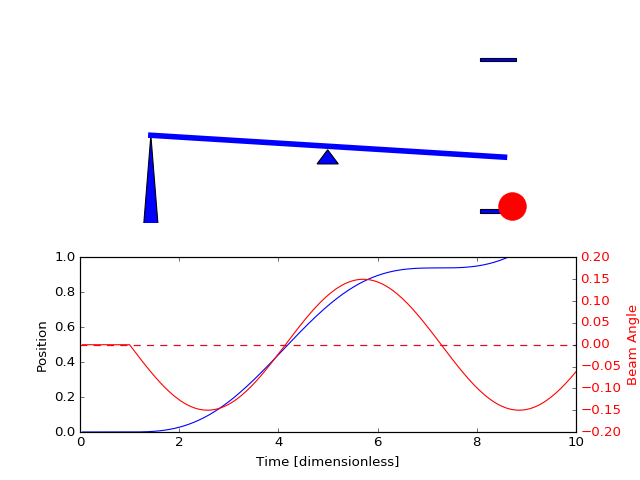

In [3]:
# simulation parameters
dt = 0.05
tf = 10.0

# initialize simulation 
t = 0.0      # initial time
x = 0.0      # initial ball position
v = 0.0      # initial ball velocity
u = 0.0      # initial beam angle
SP = 0.5     # initial set point

# set up figure window with two axes
fig,ax = subplots(2,1,figsize=(8,6))
beam_axes = ax[0]
plot_axes = ax[1]

# draw ball and beam apparatus
draw_beam(fig,beam_axes)
update_beam(fig,beam_axes,x,u,0.5)

# draw plotting axes
xplot,uplot = draw_plot(fig,plot_axes,SP)

# simulation/animation
for t in linspace(dt,10.0,10.0/dt):
    # beam angle
    u = 0.0 if t <= 1.0 else -0.15*sin(t-1.0)
    
    # update velocity and position
    v += -sin(u)*dt
    x += v*dt
    
    # update plots
    update_beam(fig,beam_axes,x,u,SP)
    update_plot(xplot,t,x)
    update_plot(uplot,t,u)
    
    # pause for time step
    # time.sleep(dt)

<a id="Proportional-Derivative Control"></a>
## Proportional-Derivative Control

The beam angle is primary control input. We choose to adjust the control using proportinal-derivative (PD) feedback in the form

$$u(t) = K_p (x(t) - x_{SP}) + K_d v(t)$$

where $K_p$ and $K_d$ are parameters determining the proportional and derivative control response.

Running the following cell defines a function to perform a closed-loop simulation of PD control for fixed values of the setpoint (`SP`), proportional gain (`Kp`), and derivative gain (`Kd`), and then runs the simulation for one choice of these parameters.

<IPython.core.display.Javascript object>


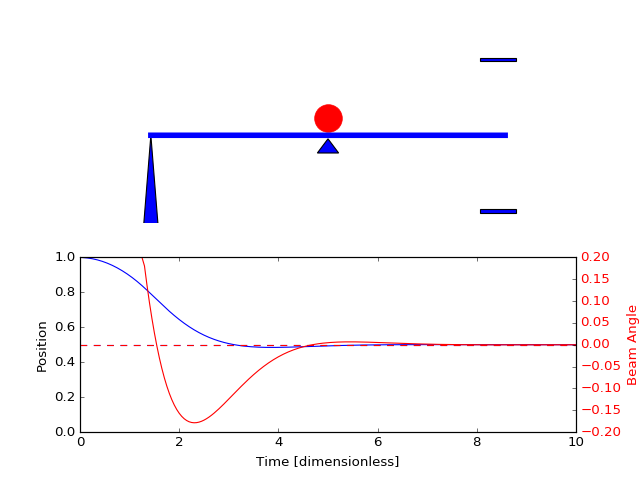

In [4]:
def ballbeam(IC, SP, Kp, Kd):
    # initialize
    t = 0.0       # time
    x = IC        # ball position
    v = 0.0       # ball velocity
    u = 0.0       # beam angle
    
    # initialize graphics
    fig,ax = subplots(2,1,figsize=(8,6))
    draw_beam(fig,ax[0])  
    xplot,uplot = draw_plot(fig,ax[1],SP)
    
    # simulation loop
    while (t < tf) & (x <= 1.0) & (x >= 0.0):
        # calculate control
        u = max(-ulimit,min(ulimit,Kp*(x - SP) + Kd*(v)))

        # update state
        t += dt
        v += -sin(u)*dt
        x += v*dt
        
        # update graphics
        update_beam(fig,ax[0],x,u,SP)
        update_plot(xplot,t,x)
        update_plot(uplot,t,u)

# run simulation for one choice of initial position, setpoint, and control gains
dt = 0.05
tf = 10.0
ballbeam(1.0, 0.5, 2.0, 2.0) 

## Interactive Simulation

Running the following cell will open a set of sliders with which you can adjust the initial position of the ball, the setpoint, and the control parameters $K_p$ and $K_d$. Adjust the sliders, then press the `Run ballbeam` button to perform the simulation. 

Try this out! For example, see if you can choose parameters to position the ball on the very tip of the beam without falling off.

<IPython.core.display.Javascript object>


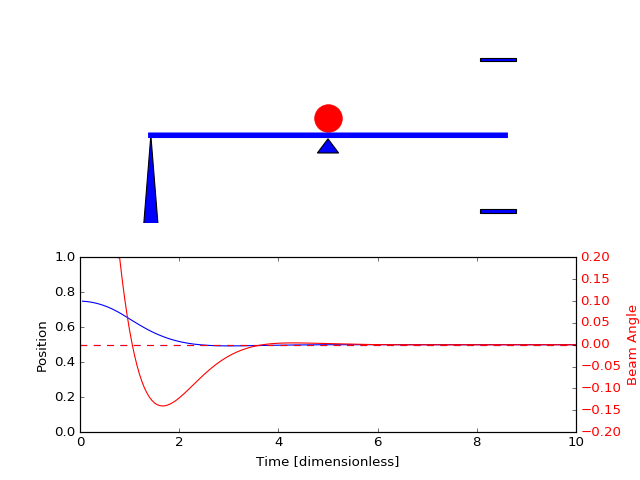

In [5]:
dt = 0.05
tf = 10.0

fig,ax = subplots(2,1,figsize=(8,6))
draw_beam(fig,ax[0])
update_beam(fig,ax[0],0.5,0.0,0.5)
draw_plot(fig,ax[1],0.5)

# add sliders and run button
interactive(ballbeam, __manual=True, \
        IC = (0.0,1.01,0.01), \
        SP = (0.0,1.01,0.01), \
        Kp = (0.0,6.01,0.01), \
        Kd = (0.0,5.01,0.01))

<a id="theory"></a>
## Theory

The purpose of this section is provide a start on the analysis of the closed-loop dynamics of the ball on beam system. You can use this as a start on some exercises intended to introduce and reinforce key concepts of feedback control and the dynamics of second order systems.

The starting point is the model derived above for the ball on beam system

\begin{align}
\frac{dx}{dt} & = v(t) \\
\frac{dv}{dt} & = - K_b \sin(u(t))
\end{align}

where the beam angle, $u(t)$, is given by a proportional derivative feedback rule where

$$u(t) = K_p (x(t) - x_{SP}) + K_d v(t)$$

The first step of the analysis is to linearize the model for small values of the beam angle. By the Taylor series expansion for $\sin(u(t))$,

$$\sin(u)  = u - \frac{u^3}{6} + \frac{u^5}{120} + \cdots $$

For small values of $u(t)$, and replacing every instance of ball velocity $v(t)$ by $\frac{dx}{dt}$ (including inside of the derivative $\frac{dv}{dt}$), we get

$$ \frac{d^2x}{dt^2} = K_{b} u$$

where

$$u(t) = K_p (x(t) - x_{SP}) + K_d \frac{dx}{dt}$$

After some rearrangements, an equation for the closed-loop dynamics of the ball on beam system is given by 

$$\frac{d^2x}{dt^2} + K_b K_p \tau_d \frac{dx}{dt} + \ K_b K_p x = K_b K_p x_{sp}$$

Use this last model in the following exercises.

<a id="Exercises"></a>
## Exercises

1. Adjust the feedback control parameters so that ball settles to a setpoint = 0.5 but without the beam hitting the angle limits.
2. Adjust the setpoint to 1.0 (i.e, the very tip of beam). Adjust the control parameters so that ball settles on the setpoint without falling off the end of the beam.
3. Using the approximate linear model for the closed-loop dynamics, consider the case of proportinal only control (i.e, $K_d = 0$). Perform a simulation.  Use the model to predict the frequency of oscillation that you observe, and compare to your simulation results.
4. Predict the frequency of oscillation, and verify your results by simulation.
5. Critical damping correponds to the smallest value of $K_d$ with no overshoot. Use the approximate linear model, and derive and expression for $K_d$ that, for given values of $K_b$ and $K_p$, results in critical damping.  Verify your results by simulation.
6. Choose values for $K_p$ and $K_d$ that provide a damping ratio of $0.7$. Consult a standard textbook for a definition of damping ratio. Verify your result by simulation.
7. Derive the transfer function from $x_{sp}$ to $x$. 